# About Dataset

  **Context**



> An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

> In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has work e exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

> You are required to help the manager to predict the right group of the new customers.



---
**Content**

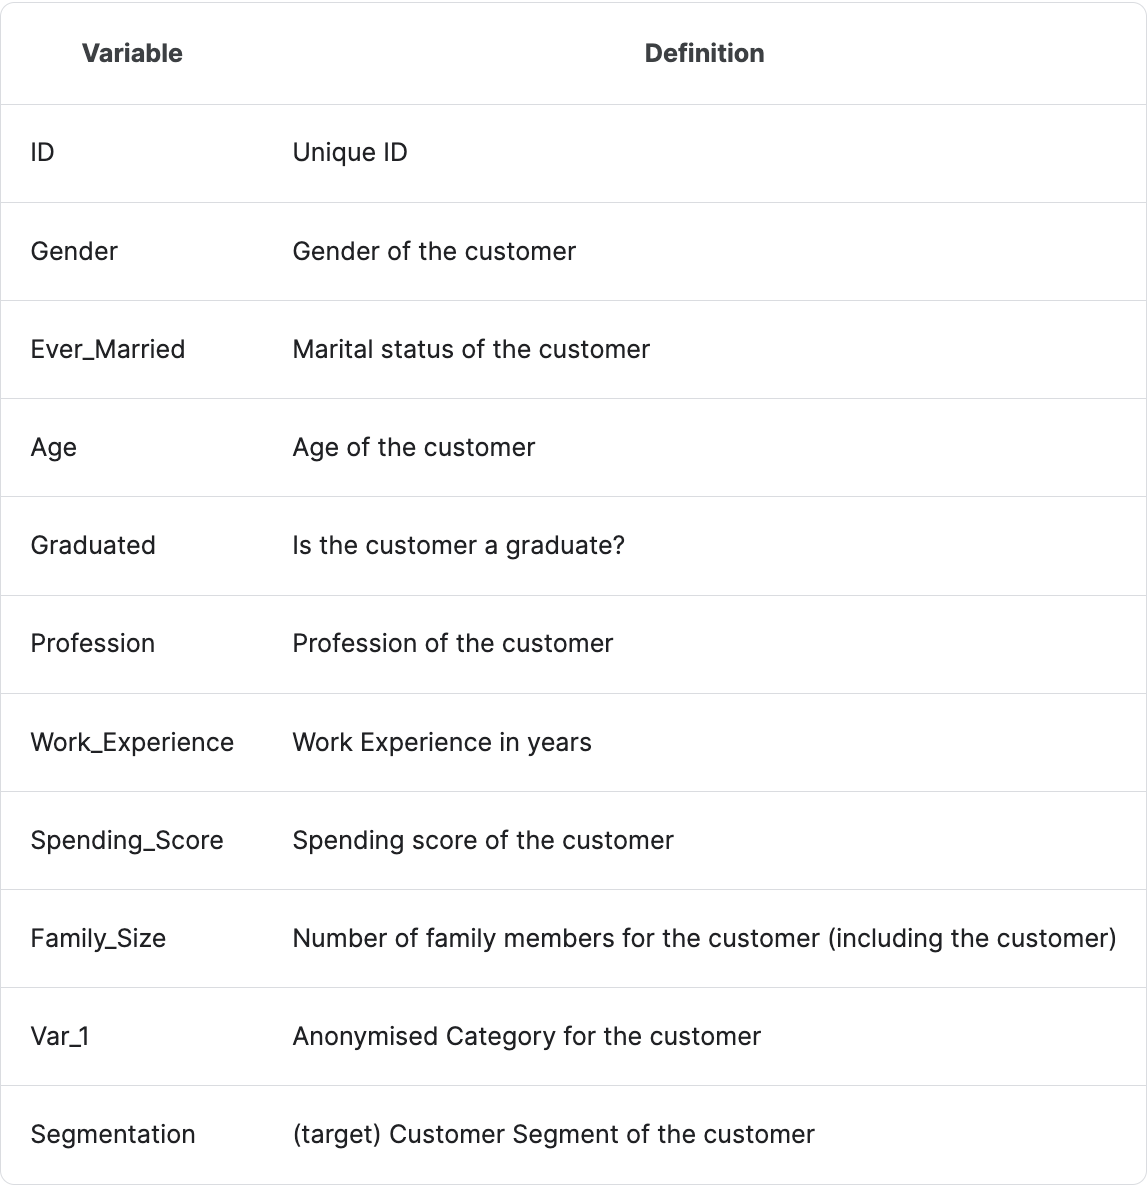








# Importing required Libraries and H20 Initialization

In [32]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [33]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [50]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [35]:
min_mem_size=6
run_time=222

In [36]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [37]:
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:11235..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpahblyvmh
  JVM stdout: /tmp/tmpahblyvmh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpahblyvmh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:11235
Connecting to H2O server at http://127.0.0.1:11235 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_xko2gi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# Importing and preprocessing the data

In [177]:
url = 'https://raw.githubusercontent.com/SangramSA/Data_Science/main/Train.csv'
df = pd.read_csv(url)
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [168]:
# checking the shape of the dataframe
df.shape

(8068, 11)

Check the datatypes of the columns whether they are numerical or categorical.

In [178]:
# printing all the datatypes of respective columns
df.dtypes

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

As we can see there are 4 numerical columns and 7 categorical columns.

The numerical columns are:
                 
1. ID
2. Age
3. Work_Experience
4. Family_Size    
                
The categorical columns are:

1. Gender              
2. Ever_Married
3. Graduated
4. Profession
5. Spending_Score
6. Var_1
7. Segmentation(Target)



In [179]:
# Checking null values
missing_values = df.isnull().sum()
missing_values

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

**Dropping the ID column**

In [180]:
df.drop('ID', axis=1, inplace=True)

**KNN Imputer to handle missing numerical data**



> `KNNImputer` is a class in scikit-learn for imputing missing values in datasets using the k-nearest neighbors algorithm. It replaces missing values with values from nearby neighbors based on similarity.








In [181]:
from sklearn.impute import KNNImputer

# Identifying numerical columns in the dataset
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Creating the KNN imputer instance
knn_imputer = KNNImputer(n_neighbors=5)

df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])


 **OrdinalEncoder**

> OrdinalEncoder is a utility class in scikit-learn used for encoding categorical features with ordinal labels. It transforms categorical variables into integers, assigning a unique integer to each category in the feature. This encoding is useful when the categories have a natural ordering, such as "low", "medium", and "high", or "cold", "warm", and "hot". The OrdinalEncoder class follows the fit-transform paradigm, where you fit it on your data to learn the unique categories and their corresponding integer labels, and then transform your data to replace the categorical values with their integer representations.



In [182]:
from sklearn.preprocessing import OrdinalEncoder

# Identifying categorical columns in the dataset
categorical_columns = df.select_dtypes(include=['object']).columns

# Creating an ordinal encoder instance (KNNImputer works with numerical data, so we need to convert categorical data to numerical)
ordinal_encoder = OrdinalEncoder()

df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   float64
 1   Ever_Married     7928 non-null   float64
 2   Age              8068 non-null   float64
 3   Graduated        7990 non-null   float64
 4   Profession       7944 non-null   float64
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   float64
 7   Family_Size      8068 non-null   float64
 8   Var_1            7992 non-null   float64
 9   Segmentation     8068 non-null   float64
dtypes: float64(10)
memory usage: 630.4 KB


In [184]:
# Creating the KNN imputer instance
knn_imputer = KNNImputer(n_neighbors=5)

df[categorical_columns] = knn_imputer.fit_transform(df[categorical_columns])

In [186]:
df['Family_Size'] = df['Family_Size'].round()
df['Ever_Married'] = df['Ever_Married'].round()
df['Graduated'] = df['Graduated'].round()
df['Profession'] = df['Profession'].round()
df['Var_1'] = df['Var_1'].round()
for column in df:

    # Select column contents by column
    # name using [] operator
    columnSeriesObj = df[column]
    print('Column Name : ', column)
    print('Column Contents : ', df[column].value_counts())

Column Name :  Gender
Column Contents :  1.0    4417
0.0    3651
Name: Gender, dtype: int64
Column Name :  Ever_Married
Column Contents :  1.0    4727
0.0    3341
Name: Ever_Married, dtype: int64
Column Name :  Age
Column Contents :  35.0    250
37.0    234
33.0    232
42.0    232
40.0    229
       ... 
78.0     29
87.0     28
76.0     27
80.0     24
85.0     22
Name: Age, Length: 67, dtype: int64
Column Name :  Graduated
Column Contents :  1.0    5013
0.0    3055
Name: Graduated, dtype: int64
Column Name :  Profession
Column Contents :  0.0    2519
5.0    1346
3.0     967
2.0     721
1.0     714
4.0     634
7.0     623
8.0     292
6.0     252
Name: Profession, dtype: int64
Column Name :  Work_Experience
Column Contents :  1.0     2385
0.0     2318
9.0      474
8.0      463
2.0      326
3.0      279
4.0      267
6.0      215
7.0      204
5.0      202
0.8       59
0.6       58
3.8       56
10.0      53
11.0      50
12.0      48
2.2       47
13.0      46
14.0      45
2.8       43
1.2   

**MinMaxScaler**

> MinMaxScaler is a preprocessing class in scikit-learn used for scaling features to a specified range, typically between 0 and 1. It transforms each feature individually by scaling it to a given range, preserving the shape of the original distribution. This scaling is useful when you want to standardize the range of features in your dataset, especially for algorithms that are sensitive to the scale of the input data, such as gradient descent-based algorithms. The MinMaxScaler class follows the fit-transform paradigm, where you fit it on your data to learn the minimum and maximum values of each feature, and then transform your data to scale each feature to the specified range.



In [187]:
min_max_scaler = MinMaxScaler()

# Scaling the training data
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns)

# Display the first few rows of the scaled training data
print(df.head())


   Gender  Ever_Married       Age  Graduated  Profession  Work_Experience  \
0     1.0           0.0  0.056338        0.0       0.625         0.071429   
1     0.0           1.0  0.281690        1.0       0.250         0.314286   
2     0.0           1.0  0.690141        1.0       0.250         0.071429   
3     1.0           1.0  0.690141        1.0       0.875         0.000000   
4     0.0           1.0  0.309859        1.0       0.375         0.528571   

   Spending_Score  Family_Size     Var_1  Segmentation  
0             1.0        0.375  0.500000      1.000000  
1             0.0        0.250  0.500000      0.000000  
2             1.0        0.000  0.833333      0.333333  
3             0.5        0.125  0.833333      0.333333  
4             0.5        0.625  0.833333      0.000000  


**Check the correlation between all features in the data**

In [188]:
df.corr()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Gender,1.000000,0.117845,0.030216,-0.031560,0.024589,-0.057247,-0.054261,0.052296,0.030563,0.026403
Ever_Married,0.117845,1.000000,0.566100,0.199163,-0.140930,-0.099700,-0.631910,-0.086731,0.083448,-0.219928
Age,0.030216,0.566100,1.000000,0.237331,0.038756,-0.197310,-0.269544,-0.286367,0.168664,-0.243552
Graduated,-0.031560,0.199163,0.237331,1.000000,-0.302856,0.031032,-0.153428,-0.226342,0.126482,-0.180421
Profession,0.024589,-0.140930,0.038756,-0.302856,1.000000,-0.024564,0.234117,0.085496,-0.043025,0.211908
Work_Experience,-0.057247,-0.099700,-0.197310,0.031032,-0.024564,1.000000,0.047614,-0.054984,0.018266,0.014898
Spending_Score,-0.054261,-0.631910,-0.269544,-0.153428,0.234117,0.047614,1.000000,-0.108411,-0.033684,0.100572
Family_Size,0.052296,-0.086731,-0.286367,-0.226342,0.085496,-0.054984,-0.108411,1.000000,-0.146589,0.197916
Var_1,0.030563,0.083448,0.168664,0.126482,-0.043025,0.018266,-0.033684,-0.146589,1.000000,-0.017660
Segmentation,0.026403,-0.219928,-0.243552,-0.180421,0.211908,0.014898,0.100572,0.197916,-0.017660,1.000000


**Create the heat map of the correlation**

<Axes: >

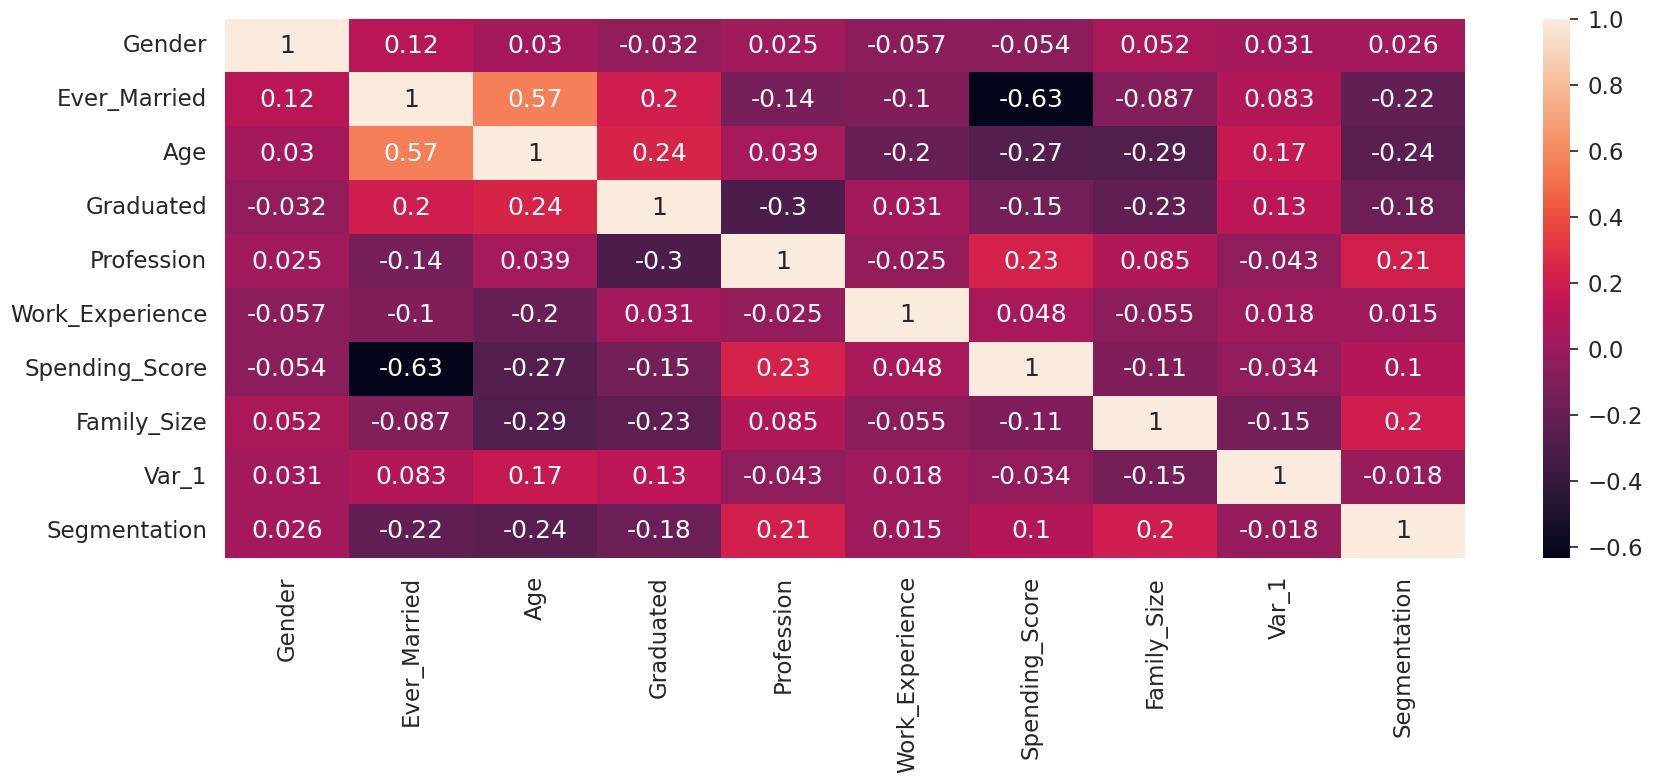

In [189]:
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(), annot=True)

In [91]:
df['Segmentation'] = df['Segmentation'].astype(int)


In [95]:
# splitting the  data into X and y variables where X is independent variables and y is target variable
X = df.drop(['Segmentation'],axis=1)
y = df['Segmentation']

**We will split the data into training and testing sets using the in-built train test split functionality of sklearn.**

In [96]:
# splitting the data into train and test split
from sklearn.model_selection import train_test_split

# splitting the data into train and test in the ratio 80:20
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

**Preparing data for H2O**


In [97]:
train = pd.concat([X_train,y_train],axis=1,keys=['X_train','y_train'])
test = pd.concat([X_test,y_test],axis=1,keys=['X_test','y_test'])

In [99]:
train.columns = train.columns.droplevel(0)
test.columns = test.columns.droplevel(0)

# H20 AutoML Execution

Creating an H2O data frame so that we can feed it to the autoMl fit function.

In [100]:
# creating a train and test H2O frame
hf = h2o.H2OFrame(train)
test_hf = h2o.H2OFrame(test)
hf.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0.28169,1,0.125,0.0714286,1,0.375,0.333333,0
0,0,0.211268,0,0.25,0,1,0.5,0.333333,1
0,1,0.43662,0,0.25,0.0714286,1,0,1,0
0,0,0.112676,0,0.5,0.571429,1,0.25,0.833333,1
0,0,0.535211,1,0.125,0.214286,1,0,0.833333,0
0,1,0.338028,0,nan,0.328571,0,0.125,0.5,1
1,1,0.732394,0,0.875,0,0.5,0.25,0,0
0,1,0.661972,1,0.875,0,1,0,0.833333,0
1,1,0.56338,0,0.5,0.857143,0.5,0.125,0.833333,0
0,0,0.253521,1,0,0.642857,1,0.25,0.5,0


In [101]:
hf.columns

['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation']

In [102]:
hf.types

{'Gender': 'int',
 'Ever_Married': 'int',
 'Age': 'real',
 'Graduated': 'int',
 'Profession': 'real',
 'Work_Experience': 'real',
 'Spending_Score': 'real',
 'Family_Size': 'real',
 'Var_1': 'real',
 'Segmentation': 'int'}

In [103]:
# setting up the dataset to split into train and test H2Oframe
hf['Segmentation'] = hf['Segmentation'].asfactor()
predictors = hf.drop('Segmentation').columns
response = 'Segmentation'

In [104]:
train_hf,val_hf = hf.split_frame(ratios=[.8],seed=1234)

In [105]:
aml = H2OAutoML(max_models=10,max_runtime_secs=300,seed=1234,exclude_algos = ["DeepLearning"])

In [106]:
aml.train(x=predictors,y=response,training_frame=hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


The above results suggest the following:

The best model that fits our data is Stacked Ensemble with total of 5 base models including GBM,XGBoost, GLM, and DRF. It also inlcluded metalearner as GLM.
The model gives an train AUC of 0.94 and val AUC of 0.89. The f1 score for train and test are 0.786 and 0.68 suggesting that precision and recall have a good balance in both train and val. Hence the model does not overfit the data.
The train and val MSE are 0.088 and 0.119 which are respectable values suggesting the model fits the data well and it makes sense.
Also the data is able to very nicely handle data imbalance. It is not biased towards the class with people having any specific segment.

In [107]:
# printing the leaderboard of top 10 models
lb = aml.leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_2_20240219_220736,0.878317,0.369286,0.768998,0.210038,0.345549,0.119404
StackedEnsemble_AllModels_1_AutoML_2_20240219_220736,0.878155,0.369616,0.768148,0.201657,0.345837,0.119603
GBM_2_AutoML_2_20240219_220736,0.876842,0.373977,0.765978,0.209957,0.347809,0.120971
GBM_3_AutoML_2_20240219_220736,0.876305,0.373579,0.767156,0.207136,0.347651,0.120861
XGBoost_3_AutoML_2_20240219_220736,0.875203,0.374945,0.764551,0.216371,0.34864,0.12155
GBM_1_AutoML_2_20240219_220736,0.874925,0.380961,0.7558,0.207992,0.349776,0.122343
GBM_4_AutoML_2_20240219_220736,0.872599,0.380073,0.761659,0.207574,0.350755,0.123029
XGBoost_1_AutoML_2_20240219_220736,0.871128,0.383348,0.758993,0.215727,0.352971,0.124589
XGBoost_2_AutoML_2_20240219_220736,0.866863,0.392421,0.753072,0.21557,0.357273,0.127644
XRT_1_AutoML_2_20240219_220736,0.864043,0.435219,0.74678,0.221906,0.356206,0.126883


Above table describes the top 10 models according to the AUC and other metrics. We will be fetching two models from the table for further analysis.

# Finding the best model and performing some analysis


In [120]:
#assign index values to all the models generated
model_index=0
index=0
gbm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=index
    break
  index=index+1
models_dict

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


{'StackedEnsemble_BestOfFamily_1_AutoML_2_20240219_220736': 0,
 'StackedEnsemble_AllModels_1_AutoML_2_20240219_220736': 1,
 'GBM_2_AutoML_2_20240219_220736': 2,
 'GLM_1_AutoML_2_20240219_220736': 11}

In [121]:
#print the index value of best model
print(model_index)
best_model1 = h2o.get_model(aml.leaderboard[model_index,'model_id'])

2


In [122]:
best_model1.algo

'gbm'

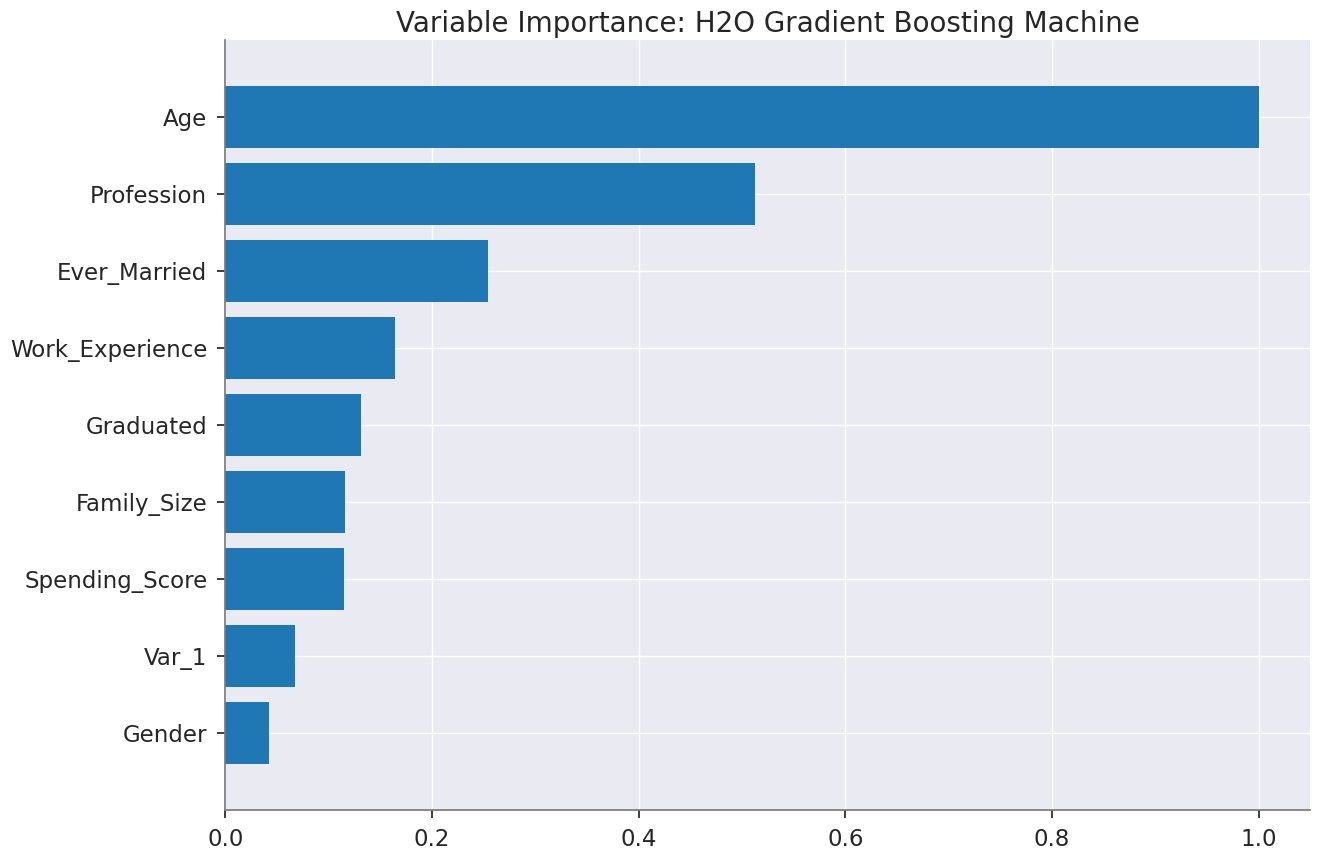

<Figure size 800x550 with 0 Axes>

In [123]:
#plot variables in order of their importance for price prediction
if best_model1.algo in ['gbm','drf','xrt','xgboost']:
    best_model1.varimp_plot()

11
glm


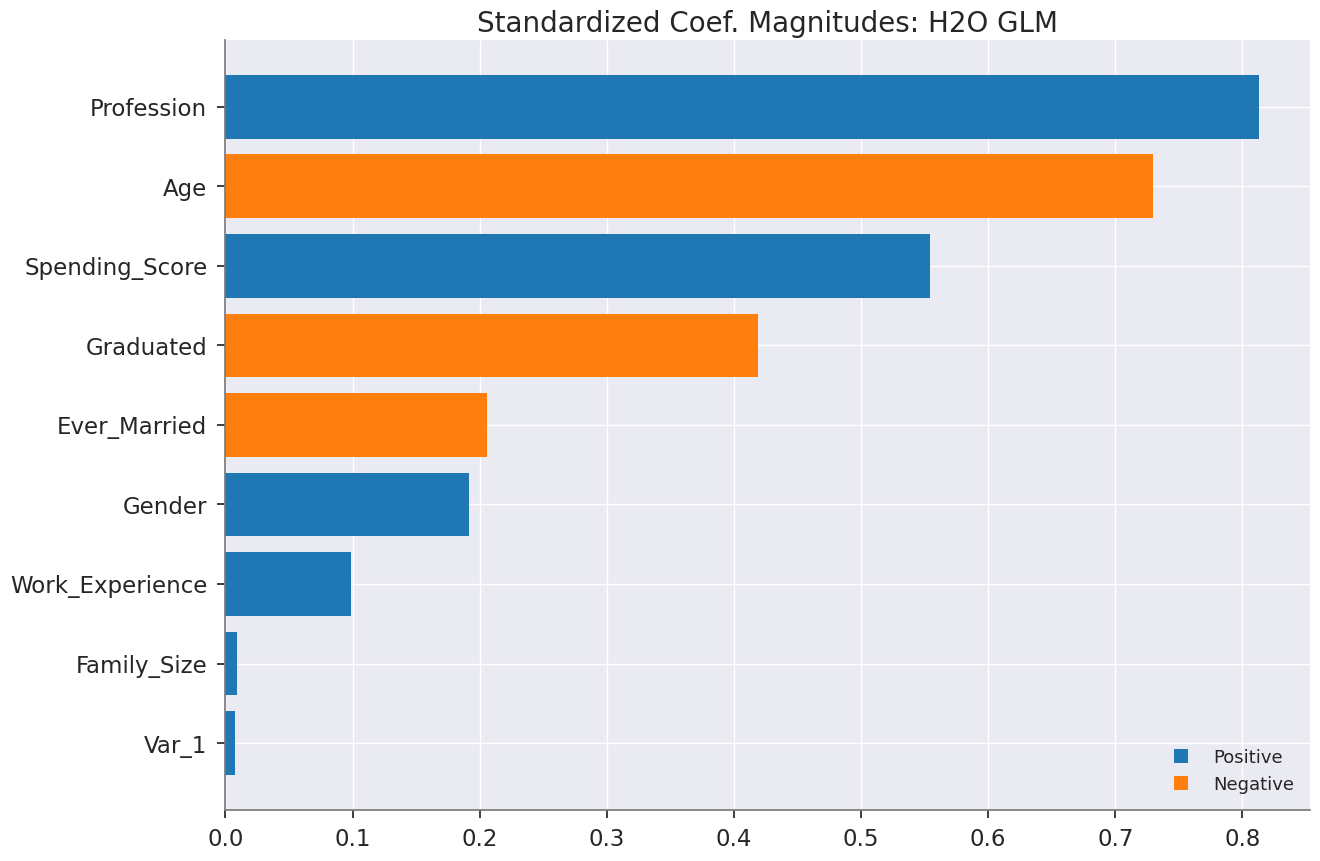

In [124]:
if index is not 0:
  print(index)
  gbm_model1=h2o.get_model(aml.leaderboard[index,'model_id'])
  print(gbm_model1.algo)
  gbm_model1.std_coef_plot()

In [125]:
hf.columns

['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation']

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GBM_2_AutoML_2_20240219_220736 on column 'Gender'.
gender    mean_response    stddev_response    std_error_mean_response
--------  ---------------  -----------------  -------------------------
0         0.259252         0.281308           0.00350161
1         0.293946         0.296113           0.00368589,
 PartialDependence: Partial Dependence Plot of model GBM_2_AutoML_2_20240219_220736 on column 'Ever_Married'.
ever_married    mean_response    stddev_response    std_error_mean_response
--------------  ---------------  -----------------  -------------------------
0               0.304512         0.285286           0.00355113
1               0.236566         0.231036           0.00287584,
 PartialDependence: Partial Dependence Plot of model GBM_2_AutoML_2_20240219_220736 on column 'Age'.
age        mean_response    stddev_response    std_error_mean_response
---------  ---------------  -----------------  -------------------------
0  

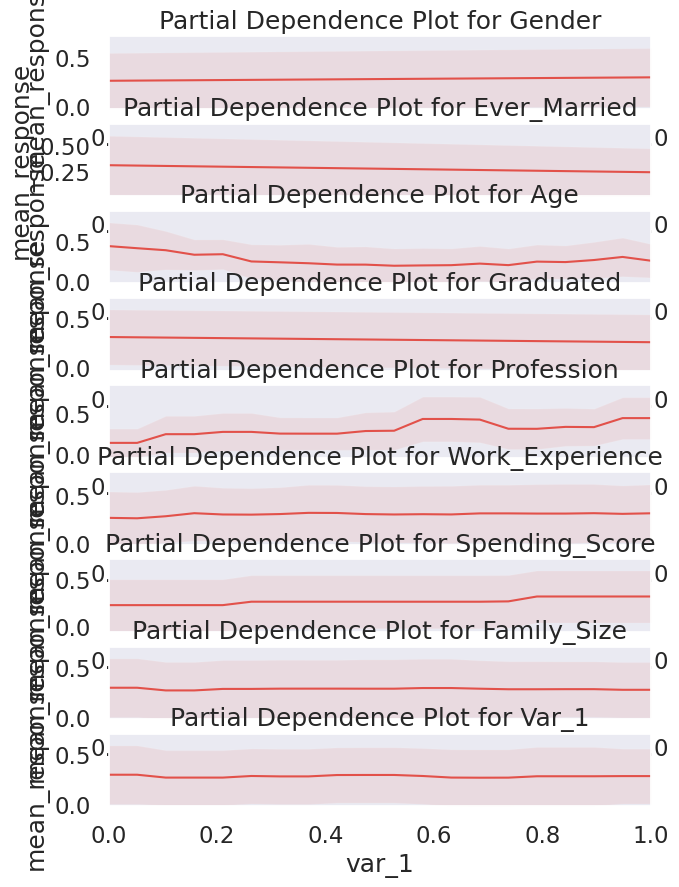

In [126]:
best_model1.partial_plot(hf, cols=['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1'])

In [127]:
best_model1.train(x=predictors,y=response,training_frame=hf)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1708374364703_1950


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          19863                  5            5            5             14            32            26.98

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10167845014214158
RMSE: 0.3188705852569998
LogLoss: 0.32140645461682343
Mean Per-Class Error: 0.18126049636126143
AUC: 0.9157115875043661
AUCPR: 0.8363321486520877
Gini: 0.8314231750087322

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3947600165197919
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4085  575   0.1234   (575.0/4660.0)
1      429   1365  0.2391   (429.0/1794.0)
Total  4514  1940  0.1556   (1004.0/6454.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39476      0.731119  189
max f2                       0.176443     0.810031  282
max f0point5                 0.559674     0.773679  117
max accuracy                 0.473086     0.855438  155
max precision                0.981356     1         0
max recall                   0.0222148    1         385
max specificity              0.981356     1         0
max absolute_mcc             0.458553     0.629286  162
max min_per_class_accuracy   0.306513     0.823857  222
max mean_per_class_accuracy  0.240125     0.828105  249
max tns                      0.981356     4660      0
max fns                      0.981356     1791      0
max fps                      0.0102276    4660      399
max tps                      0.0222148    1794      385
max tnr                      0.981356     1         0
max fnr                      0.981356     0.998328  0
max fpr                      0.0102276    1         399
max tpr                      0.0222148    1         385

Gains/Lift Table: Avg response rate: 27.80 %, avg score: 27.81 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010846                    0.977782           3.59755    3.59755            1                0.978568   1                           0.978568            0.039019        0.039019                   259.755   259.755            0.039019
2        0.0213821                   0.976989           3.59755    3.59755            1                0.977369   1                           0.977977            0.0379041       0.0769231                  259.755   259.755            0.0769231
3        0.0303688                   0.976064           3.59755    3.59755            1                0.97652    1                           0.977546            0.03233         0.109253                   259.755   259.755            0.109253
4        0.0407499                   0.975467           3.59755    3.59755            1                0.975845   1                           0.977113            0.0373467       0.1466                     259.755   259.755            0.1466
5        0.0503564                   0.972245           3.59755    3.59755            1                0.974245   1                       

The above results suggest the following:


*   The AUC value of 0.915 suggests a good magnitude of precision and recall.
*   MSE of 0.101 is really good indication of fit to the model.

*   The True positive and False positive rate values have a good balance for the dataset.

Interpretation of evaluation metrics.



*   max precision: The model demonstrates a high ability to correctly classify positive instances while minimizing false positives. This suggests that when the model predicts a positive outcome, it is often correct.
*   max recall: The model captures a high proportion of actual positive instances. It indicates a strong ability to identify positive cases when they occur, but it may come at the cost of increased false positives.

*   max specificity: The model effectively identifies true negatives, which is important when minimizing false alarms is a priority. It suggests that the model is good at classifying negative cases correctly.







# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1708374364703_1950

,0,1,Error,Rate
0,747.0,165.0,0.1809,(165.0/912.0)
1,58.0,298.0,0.1629,(58.0/356.0)
Total,805.0,463.0,0.1759,(223.0/1268.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

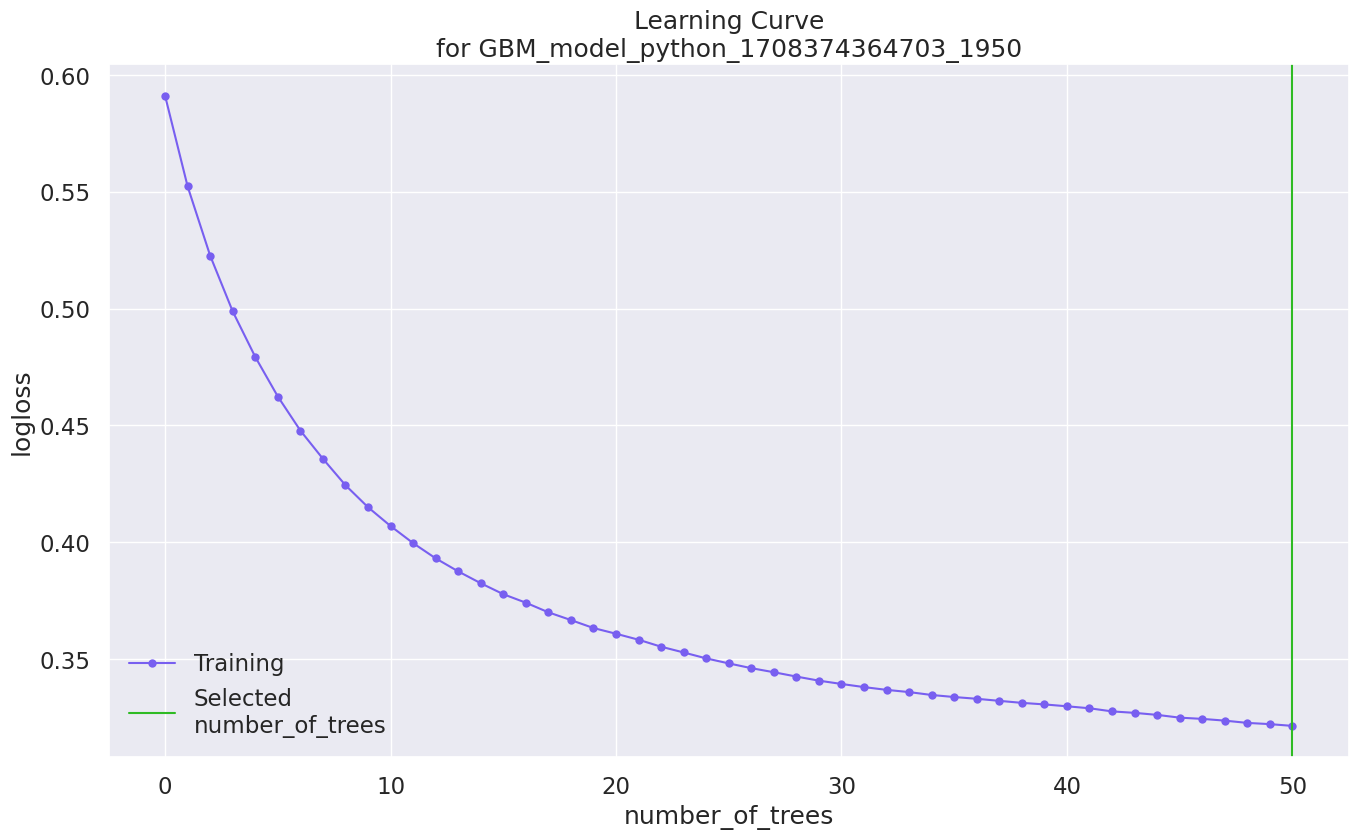

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

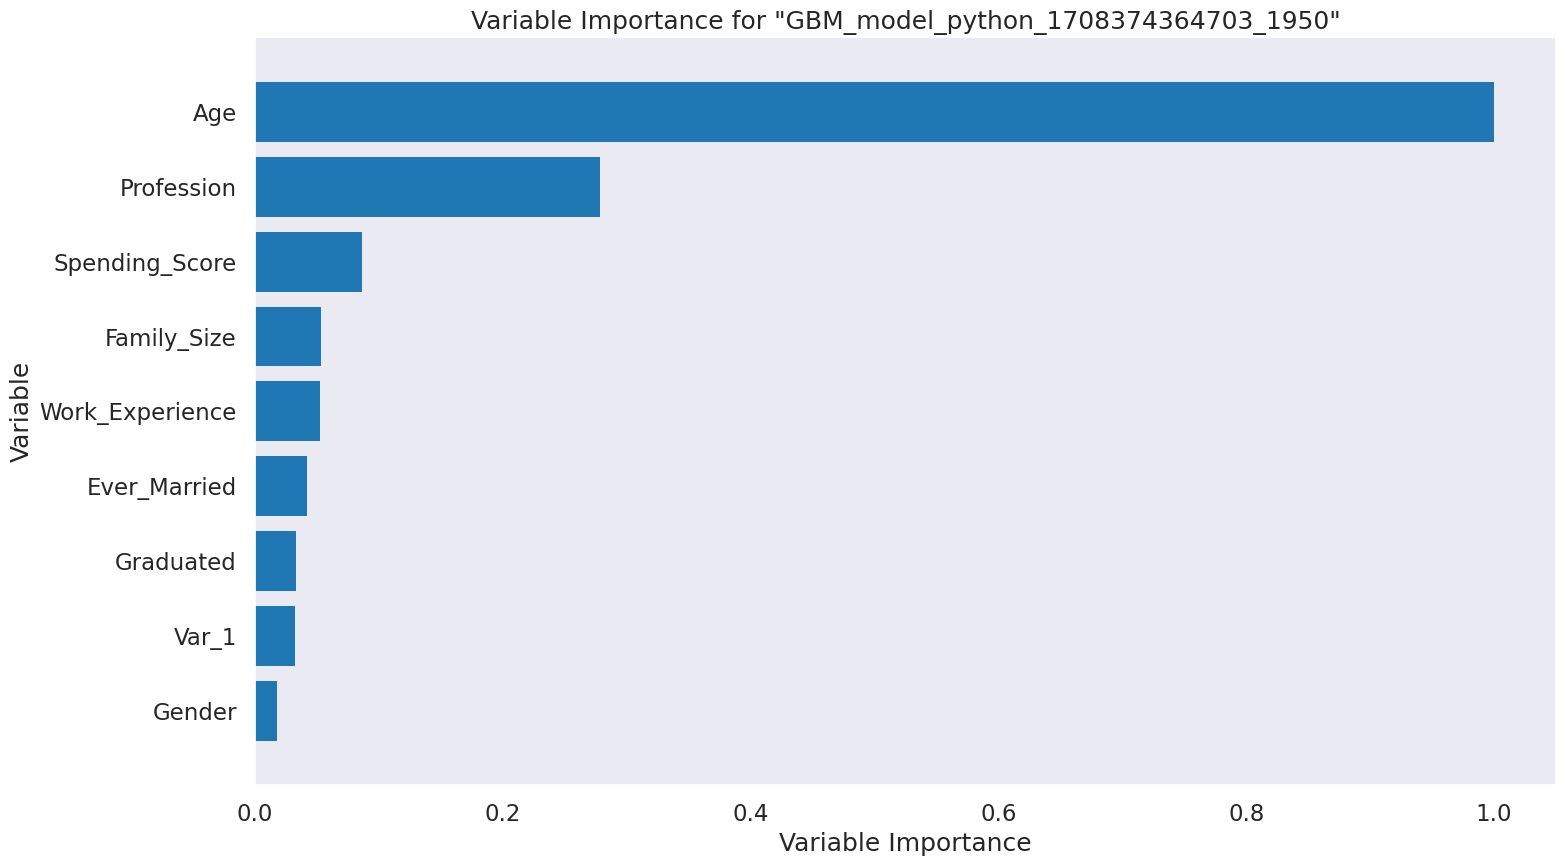

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

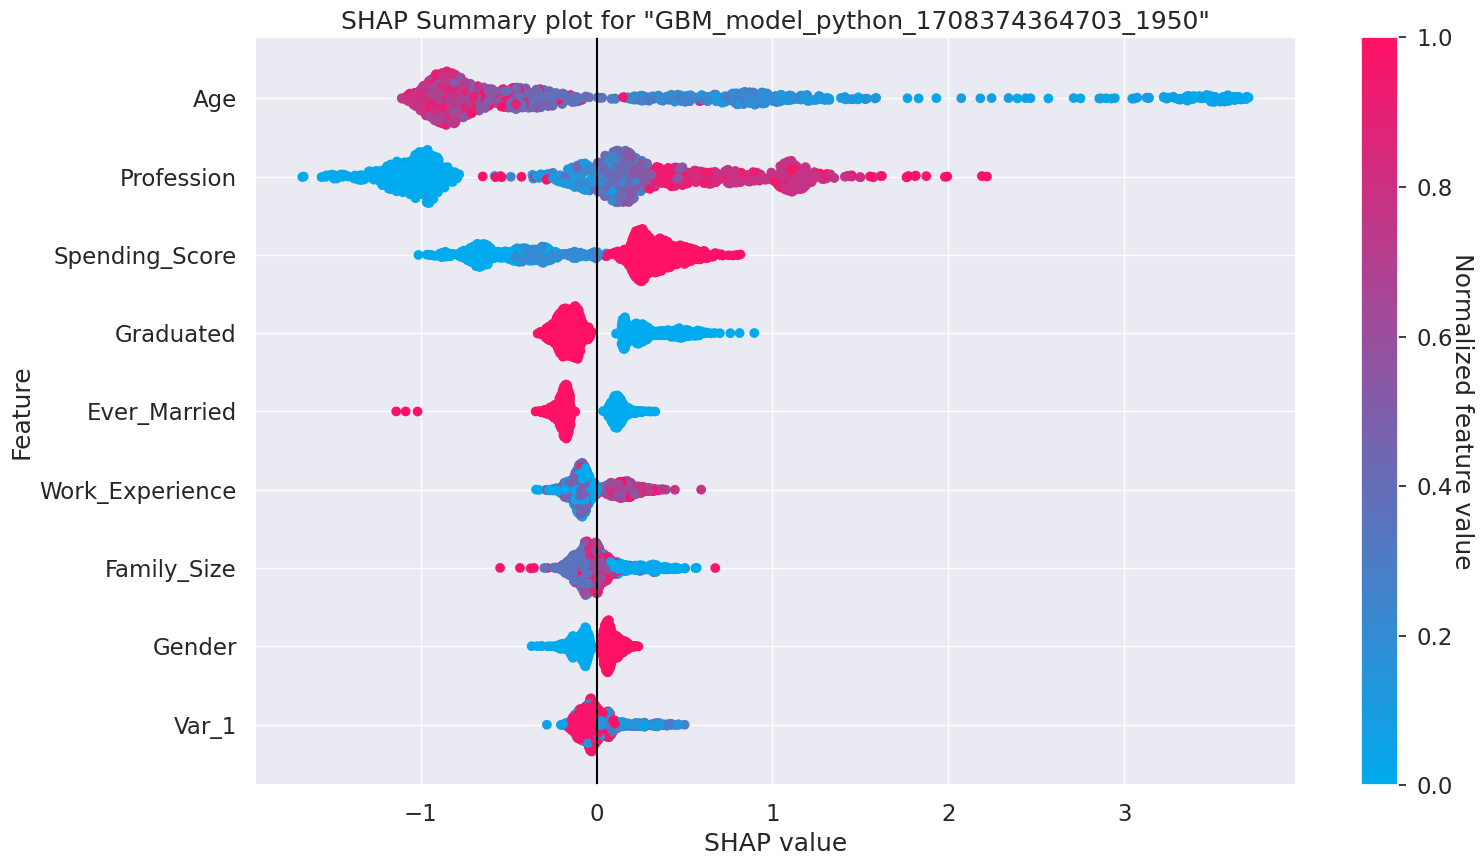

In [128]:
exm = best_model1.explain(val_hf,exclude_explanations=['pdp','ice'])

Above displayed plots suggest the following:

*   For the learning curve plot as the iterations increase the loss eventually decreases till no of trees are 50 and then becomes constant. This proves that the model does not overfit the data because in that case, the loss would again start increasing with further iterations.

* The variable importance plot shows the relative importance of the most important variables in the model. The most imporant features are Age and Profession

* SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. The SHAP summary plot also justifies the variable importances and feature contributions.

###**Hyperparameter Tuning**

In [131]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [136]:
# Step 1: Define the Hyperparameter Grid
hyperparameters = {
    'learn_rate': [0.01, 0.2],
    'ntrees': [50, 100, 150],
    'max_depth': [3, 5, 9],
    'sample_rate': [0.8, 1.0],
    'col_sample_rate': [0.2, 0.5, 1.0]
}


# Create the grid search object
grid = H2OGridSearch(model=best_model1,
                    hyper_params=hyperparameters)

# Train the models with different hyperparameter combinations
grid.train(x=predictors, y=response, training_frame=hf)

# Get the best model based on a specified metric (e.g., logloss)
grid_sorted = grid.get_grid(sort_by='logloss', decreasing=False)
best_model = grid_sorted.models[0]

# Make predictions and evaluate the best model
predictions = best_model.predict(test_hf)

# Evaluate the model's performance
performance = best_model.model_performance(test_hf)
print("Best Model Performance:")
print(performance)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Best Model Performance:
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.15071499838761368
RMSE: 0.3882202962077249
LogLoss: 0.5343888860857328
Mean Per-Class Error: 0.23437708194536974
AUC: 0.8613988822266637
AUCPR: 0.7614500584320457
Gini: 0.7227977644533274

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39549118500058217
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      976   164  0.1439   (164.0/1140.0)
1      154   320  0.3249   (154.0/474.0)
Total  1130  484  0.197    (318.0/1614.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395491     0.668058  201
max f2                     

In [138]:
# Extract and print the best hyperparameters
best_hyperparameters = best_model.actual_params

best_hyperparameters

{'model_id': 'Grid_GBM_py_9_sid_ad6b_model_python_1708374364703_6362_model_54',
 'training_frame': 'py_9_sid_ad6b',
 'validation_frame': None,
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'Segmentation',
 'ignored_columns': None,
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'ntrees': 150,
 'max_depth': 9,
 'min_rows': 10.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': -9060280444968440080,
 'build_tree_one_node': False,
 'learn_rate': 0.

So the above array shows the best hyperparamters found. From our given set of hypeparameters , the best results are acheived for sample_rate = 0.8 ,ntrees = 150, max_depth = 9, col_sample_rate = 1.0 and learn_rate of 0.2

###**Regularization**

In [139]:
# Create a new GBM model with manual regularization settings
new_gbm_model = H2OGradientBoostingEstimator(
    ntrees=100,
    learn_rate=0.01,  # Shrinkage
    max_depth=5,  # Limiting tree depth
    sample_rate=0.8,  # Row sampling
    col_sample_rate=0.8,  # Column sampling
    stopping_rounds=5,  # Early stopping parameters
    stopping_metric='auto',
    stopping_tolerance=0.0005,
    seed=123  # For reproducibility
)

# Train the new model using the same data and settings as the existing model
new_gbm_model.train(x=predictors, y=response,training_frame=hf)

# Make predictions and evaluate the new model as usual
predictions = new_gbm_model.predict(test_hf)
performance = new_gbm_model.model_performance(test_hf)
print("New Model Performance:")
print(performance)
print("Old model Performance")
print(best_model1.model_performance(test_hf))

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
New Model Performance:
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13495465390261674
RMSE: 0.3673617480122512
LogLoss: 0.4288651478081371
Mean Per-Class Error: 0.2036475682878081
AUC: 0.8776352801835813
AUCPR: 0.7796724924455982
Gini: 0.7552705603671626

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3062909819529869
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      921   219  0.1921   (219.0/1140.0)
1      102   372  0.2152   (102.0/474.0)
Total  1023  591  0.1989   (321.0/1614.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306291     0.698592  200
max f2                       0

In both cases there is insignificant changes in values. Hence regularization does not help much




























In [193]:
import statsmodels.formula.api as smf #OLS model Library
results = smf.ols('Segmentation ~ Gender + Ever_Married + Age + Graduated + Profession + Work_Experience + Spending_Score + Family_Size + Var_1', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Segmentation   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     137.1
Date:                Tue, 20 Feb 2024   Prob (F-statistic):          1.69e-241
Time:                        02:41:34   Log-Likelihood:                -3059.5
No. Observations:                8068   AIC:                             6139.
Df Residuals:                    8058   BIC:                             6209.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5397      0.022     24.860      0.000       0.497       0.582
Gender              0.0221      0.008      2.751      0.006       0.006       0.038
Ever_Married       -0.0994      0.012     -8.086      0.000      -0.123      -0.075
Age                -0.2635      0.022    -11.734      0.000      -0.308      -0.219
Graduated          -0.0367      0.009     -4.091      0.000      -0.054      -0.019
Profession          0.2305      0.014     16.853      0.000       0.204       0.257
Work_Experience    -0.0231      0.017     -1.330      0.184      -0.057       0.011
Spending_Score     -0.0547      0.013     -4.349      0.000      -0.079      -0.030
Family_Size         0.2234      0.023      9.700      0.000       0.178       0.269
Var_1               0.0778      0.017      4.557      0.000       0.044       0.111
==============================================================================
Omnibus:                     3029.320   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.527
Skew:                          -0.287   Prob(JB):                    4.58e-110
Kurtosis:                       1.919   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
# Assuming X is the DataFrame containing only predictor variables
X = df.drop('Segmentation', axis=1)  # Replace 'TargetVariable' with the actual target variable

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

           feature       VIF
0           Gender  2.223996
1     Ever_Married  4.895509
2              Age  5.853623
3        Graduated  2.995207
4       Profession  2.618130
5  Work_Experience  1.668627
6   Spending_Score  4.300797
7      Family_Size  2.300465
8            Var_1  7.458699


# Conclusion

A model based on Gradient Boosting Machine is used classify the a customer to a segment. VIF, p-values and other tests were considered to ignore some of the independent variables. H20.ai framework was used to train and test the variables of the dataset. This gave the best model as ‘gbm’ and accuracy for test data was 85%. From the results shown it can be concluded that the proposed model can effectively analyze and predict the ISegmetation to some extent. Admittedly, the prediction accuracy is still limited at specific points, and the model still needs to be improved in further research. In further research into the corresponding models, more advance techniques can help achieve better prediction.

# Assignment Question/Answers

Q1) Is the relationship significant?

A relationship is said to be statistically significant when the p value for the variables is less than 0.05.P value is probability of obtaining a result at least as extreme as the current one, assuming null hypothesis is true. A small p value depicts that there is very little similarity between the two groups and hence null hypothesis can be ignored. P-value was calculated by two ways for this model. From the OLS method it was observed that values for 'IWork_Experience' was greater than 0.05. So, it can be concluded that other that p-value for all the variables of dataset is less than 0.05. Hence for the chosen dataset it can be concluded that the relationship is significant.

Q2) Are any model assumptions violated?

Model assumptions for classification are as follows: • It assumes that there is minimal or no multicollinearity among the independent variables. • It usually requires a large sample size to predict properly. • No model assumptions are violated because no multicollinearity is observed in the model, sample size is large.

Q3) Is there any multicollinearity in the model?

 Multicollinearity can be determined by computing correlation matrix or calculating VIF value of all variables. In correlation matrix a coefficient closer to +1 or -1 tells us that those two variables are highly correlated. None of the variables had a coefficient higher than 0.7.For VIF values a value above 10 tells us that multicollinearity exists. In this model none of the variables had VIF value greater than 10.

Q4) In the multivariate models are predictor variables independent of all the other predictor variables?

As per the correlation matrix, all predictor variables are independent of all other predictor variables as the absolute value is less than 0.7 for all the predictor variables.

Q5)In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

From the variable importance plot, the most to least important variables are displayed. For my model Age, Profession, Spending_Score, Family_Size , Ever_Married, Graduated, Var_1, Gender are top 4 most important variables to determine Segmentation.

Q6) Does the model make sense?

For a model to make sense it should follow all the assumptions and have p value, VIF between their respective ranges. RMSE should be as low as possible considering the minimum and maximum values of the target variable. Other than that, R2 too is 0.60 which is considered good in terms of accuracy. So overall the model makes sense. To increase the accuracy, some additional variables can be dropped depending on their importance. Furthermore, outliers can be removed or boosting, or ensemble model can be used.

Q7)Does regularization help?

Regularization is a technique used for tuning the random noise function by adding an additional term to noise function. This additional term controls the excessively fluctuating function such that the coefficients don’t take extreme values and the prediction of target value for test data is not highly affected. The main use of Regularization is to minimize the validation loss and try to improve the accuracy of the model. For this model it was observed that Root Mean Square Error (RMSE) and R2 was calculated twice, once when regularization was not applied and once when regularization was applied. The values were same in both the cases. Hence it can be concluded that for this model regularization does not help.

Q8) Which independent variables are significant?

Variables are significant when p-value is less than 0.05. For this model almost all the variables are significant.

Q9) Which hyperparameters are important?

To find best set a hyperparameter and combinations of interacting hyperparameters for a given dataset hyperparameters tuning is used. It objectively searches different values for model hyperparameters and chooses a subset that results in a model that achieves the best performance on a given dataset. For this model tuning is performed using GBM. The best hyperparameters for this model are:- sample_rate = 0.8 ,ntrees = 150, max_depth = 9, col_sample_rate = 1.0 and learn_rate of 0.2

# REFERENCES

H20.ai- https://docs.h2o.ai/

GitHub Notebook: https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb

GBM Model- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

GBM theory: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Model Evaluation: https://piml.medium.com/gbm-model-evaluation-beyond-prediction-accuracy-397248b5cef0

GitHub Notebook: https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Melbourne_Housing.ipynb

Kaggle Notebook- https://www.kaggle.com/code/nyinyeinaung/customer-segmentation-multiclass-classification

Dataset- https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation

# MIT License

Copyright (c) 2024 SangramSA

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.